# Particle Swarm Optimisation

## -> Sphere Function

In [36]:
import numpy as np
import itertools
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random

The following will be the goal ("fitness") function. Here it is to be minimised.

## Sphere Function

In [37]:
def sphere_function(pos,dim):
    big_sum = 0
    for i in range(dim):
        big_sum = big_sum + pos[i]**2
    return big_sum

## Rastrigin Function

In [38]:
def rastrigin_function(pos,dim):
    big_sum = 10*dim
    for i in range(dim):
        big_sum = big_sum + pos[i]**2 - 10*math.cos(2*math.pi*pos[i])
    return big_sum

## Algorithm

In [124]:
class Particle: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim

        self.fitness = sphere_function(self.position,dim)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = sphere_function(self.position,self.dim)
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, a3, best_self_pos, best_swarm_pos, swarm):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        r3 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
        
        # Adding repulsion
#         repulsion_component = a3*calculate_z(swarm,self.position,r3)
        
        result = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        return result


In [125]:
def calculate_z(particle_swarm,particle,r3):
    result = -sum([np.divide(
        (np.multiply(r3,np.subtract(particle_other.position,particle))),
        (np.subtract(particle_other.position,particle)@np.subtract(particle_other.position,particle))
        )
        for particle_other in particle_swarm])
    return result

In [126]:
class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, a3, dim, population_size, time_steps, search_range):

        self.w = w # Inertia
        self.a1 = a1 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.a3 = a3
        self.dim = dim
        self.population_size = population_size

        self.swarm = [Particle(dim,-search_range,search_range) for i in range(population_size)]
        self.time_steps = time_steps

        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100

    def run(self):
        bests = []
        for t in range(self.time_steps):
#             if t > 300:
#                return bests[len(bests)-1],t
            
            counter_inefficient_particles = 0
            for p in range(len(self.swarm)):
                
                # Particle and his updated position
                particle = self.swarm[p]
                new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, self.a3,
                                                                      particle.best_particle_pos, 
                                                                      self.best_swarm_pos,self.swarm)    
                    
# RESTRICTIONS!
                if new_position@new_position > 1.0e+18: 
                    return bests[len(bests)-1],self.time_steps

                if change_direction(particle.position,new_position,self.dim)==False:
                    counter_inefficient_particles = counter_inefficient_particles+1
 
                self.swarm[p].setPos(new_position)
                new_fitness = sphere_function(new_position,self.dim)

                if new_fitness < self.best_swarm_fitness:  
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position
                    
            bests.append(self.best_swarm_fitness)


            if counter_inefficient_particles/self.population_size>0.7:
                return bests[len(bests)-1],t
        
        
        return bests[len(bests)-1],t

In [127]:
def change_direction(old_position, new_position, dim):
    delta_vector = old_position - new_position
    delta_sphere = delta_vector @ delta_vector
    if math.sqrt(delta_sphere) < 0.1*dim:
        return False
    return True

# Sphere function

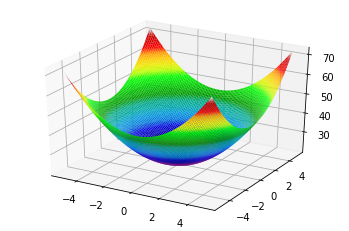

In [122]:
# Sphere

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
 
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2) + (Y**2) + 20
 
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.imshow(Z)
plt.show()

## Finding best Alpha1 and Alpha2

In [128]:
alpha1 = np.linspace(-5.12,5.12,30)
alpha2 = np.linspace(-5.12,5.12,30)
# w = np.linspace(0,1,100)
w = 30*[0.7]

# random_combinations = random.sample(set(itertools.product(w,alpha1,alpha2)), 1000)
all_possible_combinations = list(set(itertools.product(w,alpha1, alpha2)))

def automator(random_combinations):
    output = []
    for params in random_combinations:
            weight = params[0]
            alpha1 = params[1]
            alpha2 = params[2]
            best_score,num_runs = PSO(dim=2, w=weight, a1=alpha1, a2=alpha2, a3=2.02, population_size=3, time_steps=1000, search_range=5.12).run()
            output.append((weight,alpha1,alpha2,best_score,num_runs))
    return output
    
result = automator(all_possible_combinations)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs'])
df.sort_values('best_score', inplace=True)
print(df)

       w   alpha 1   alpha 2    best_score  num_runs
744  0.7 -0.176552  4.413793  1.410373e-06      1000
87   0.7 -1.588966  4.413793  1.775699e-06       482
267  0.7 -2.295172  3.707586  3.569876e-06       159
585  0.7 -0.882759  4.060690  3.932207e-06       295
79   0.7 -1.942069  3.001379  5.024266e-06       294
..   ...       ...       ...           ...       ...
229  0.7 -4.060690 -4.413793  3.853835e+06      1000
571  0.7  5.120000  5.120000  4.209603e+06      1000
170  0.7  3.354483 -5.120000  5.340844e+06      1000
201  0.7 -4.413793 -4.060690  6.007949e+06      1000
628  0.7 -0.882759 -5.120000  6.196637e+06      1000

[900 rows x 5 columns]


In [129]:
print(df["best_score"].mean())

178331.4548290048


In [130]:
print(df["num_runs"].mean())

793.3922222222222


In [91]:
best_score,num_runs = PSO(dim=10, w=0.7, a1=2.02, a2=2.02, a3=2.02, population_size=3, time_steps=1000, search_range=5.12).run()
print(best_score)
print(num_runs)

1268935.930445261
1584115.7649688208
2442762.61081083
1577602.47128546
5924036.2582527045
11601044.737676444
501167.39094346133
8390988.581958855
23465321.59512079
161076.31250873834
7086612.515541247
57507052.94816892
69435.02464150019
3825845.7900676224
103784520.58459093
100734.40771661818
1811437.9497257501
77262279.15675831
5665.238252464953
3807212.511163245
82479374.88057539
3001.3214350971557
14367831.387438938
63316603.49339105
122.58241740886032
12312801.856557231
13016122.364120038
410.1794875702468
3611526.1255920646
8816513.160721239
155.06071537192278
3560339.18822056
11182510.107504774
58.991510774508725
6595159.245987501
14767511.517219763
9.430085745414354
11829839.342632715
19933539.901848014
2.2601628678804895
40788883.89442501
10563272.816116706
10.31305403147408
26544019.446183976
12289815.147148492
5.947420941952104
7318260.651843987
7324665.669237701
11.799276681336032
36289160.180528335
1401055.8434809314
12.89423329455321
85584588.40853651
1521599.4256422557
9.

50.38578553461358
1408.7771660677604
24164.47456550088
27.70672465490936
603.2542055151487
87879.37339527978
23.736632557814787
37.63038564346379
152765.0830788039
11.49697896641808
15.076827699790893
135635.37640743356
12.080457376027198
36.465653441724356
7484.6378163050185
16.157460894657245
85.6037014278536
68339.41737283202
15.96139442173391
117.21280724049814
59938.211463726635
9.022530890136387
79.8352939833772
2381.6913361265797
17.80113415886793
42.55093286261143
27893.405061700894
58.15637692320925
54.88704151967788
113953.38265037503
113.01462115251292
112.69501679373407
172218.42466108827
370.30275626375703
293.94454280404216
67477.36234058342
1279.401425418506
531.5023674746631
45926.194877208414
782.81227523493
427.44580433104113
123615.36517350364
137.20031429036771
423.3246476234772
122191.18248185543
102.45581409731423
476.0937815245055
56105.0385439235
38.054279767318675
88.46249235798635
85438.84197813566
16.765047210140352
463.97090227698976
279835.33947619976
19.08

In [92]:
df["num_runs"].mean()

822.1455555555556

### Plotting alpha1 vs alpha2

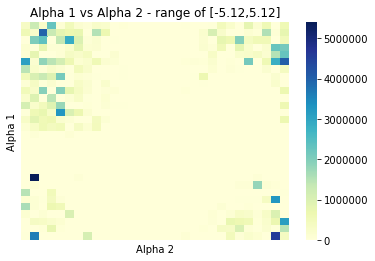

In [93]:
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
data = df.iloc[:,[1,2,3]]
data = data.pivot(index='alpha 1', columns='alpha 2', values='best_score')
sns.heatmap(data,xticklabels=False,yticklabels=False,cmap='YlGnBu')
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Alpha 1 vs Alpha 2 - range of [-5.12,5.12]')
plt.xlabel("Alpha 2")
plt.ylabel("Alpha 1")


plt.savefig('alpha1_alpha2_sphere.pdf') 

plt.show()

## Finding best w

       w   alpha 1   alpha 2  best_score  num_runs
494  0.7  4.413793 -3.001379    0.000004       999
588206.323743818
69391.63793559693
137481.512855088
513865.6037740654
513864.94596187404
71231.07701082456
2601461.4144831537
646079.6113503698
98720.57708164414
16024007.453854375
410479.1793547227
46997.11269631708
44572678.30979165
1414648.9795821114
131338.31185766522
230832305.9330822
50962994.89150685
3723.4783396326234
8745946.036675742
30556789.98803459
4212.008149284096
749817543.3491597
297485.7383631861
20407.060688541897
15803.405446660136
183201.4779370407
172806.18464087727
2457442635.4064035
469278.4421644775
3761.1134994972344
10588702977.842558
76423.57316750029
131.40364745561425
341648438528.932
273813.389310162
329563.53197139536
148857540034.45245
3747995.0257285577
2202580.5574350357
51168502.626289025
999838.0643691671
600305.1744090455
175817486.41253635
15288461.452253204
134500.9061320515
1061378108.043921
108740514.19800195
797306.0501995203
3902019.365863231

134071944034397.12
450741.33107425243
63.7671507223608
41688292051391.0
73360.70489964026
445.29057519596944
7856063941277.986
44.033113787274885
472.18949795188274
97220240159901.61
2939.650397465816
365.0934018657549
64123482962451.16
412.6260927722227
5.4227396416397315
621078805058.5881
52.02742797976176
75.81605129989524
20499766135647.875
172.73307794796716
604.0255381242949
57491901756918.52
193.95018614772505
40.20562691015661
5362931252773.987
103.53186252640931
695.6338977024988
25683113115.05747
1566.660210539905
1383.9605863698275
8473026472759.761
192.83162599390653
3.76842066146909
16035948539417.074
5.082893144677387
8.415358669293672
89571191519.38469
85.76970025382904
81.93405186559002
361292445729.5719
174.39388522046568
1426.8001459727957
41132329696436.93
293.62284687107467
3217.306787372382
96882738780.45317
191.60267605872792
243.61380806440124
6899266325557.036
18.406104448322665
12740.036321293728
1643755072820.6477
13.296225781157522
1990.0385517799234
14119573

19860.259910511202
601311.291102938
45032.57627629804
3707.814357502905
188068.69088061593
13203.304975758465
177.36185925250174
838240.3467276423
79.46124406019271
9779.73466342455
76659.89095694118
4903.904635595313
20162.57524253485
415672.8068283489
15381.78960521599
34022.098077676856
74218.50283888685
3296.8657430593503
114784.80588797857
3972.4626965351586
188.7553199181177
8448.529007452955
12011.172757358778
30420.131391397037
8411.08826286105
2334.8646367157457
4870.930991882649
2786.4645966921153
1515.165504086903
1955.2591165914307
5995.795478211162
2521.8108500321973
266.92588153683556
38721.17314502581
8242.578723854935
101.88222206214039
400.22072325401314
7533.162416527416
0.32146454160335874
4214.144261439838
16945.41046060493
20.662938124700762
11253.961440960176
453525.31067853037
36.21374979121781
152423.1049713296
1385260.7696244242
0.6519076603064757
378061.4725622029
87234.06918941902
6.349568320038357
4396.384916033236
574085.7686128991
12.598514340430018
1385.5

385133742.11583453
3871463.6083715907
73468.6708015606
272656158.0032103
391483.3919299448
1867617.1307538885
7108149.669865167
214547.01617327612
9127953.026029997
73778.89833442216
348803.8939913999
13813722.708202016
558204.1018147981
1528454.223168882
15597850.852166388
2785117.7509677126
227940.96637490866
21087868.607525464
1892760.2063715344
167796.42969170824
15178778.258495133
3575904.2851975956
35591.124567667866
613451.3522569307
2370138.722654309
1858689.0655455547
11146623.354606157
1822543.8879348638
10123132.859875808
256412.50394041283
2588932.142540725
72440.67102884613
8222098.738097314
92.16840286127453
8230246.571954587
173513405.86088976
419396.3729620827
4433476.381427502
625888631.1585046
11985275.794091165
1727783.6443592545
2134249955.8968217
16365088.963570207
94913787.2183018
14055762071.74754
1294754.7927456824
15130217.606867203
19453468868.689663
5855902.82351656
15190752.312552439
14412550003.874039
398.0023951226341
6851174.316823397
92576882338.03651
15

63038980.409877494
48299.59422958965
7064.879134455655
2663110.258958112
759.391396089576
270.85983408722024
29274077.89533088
6.139423922889582
4.9728160289350765
3555212.837610408
43.49328438176859
116.71091497761495
15008665.703793492
145.03839625938537
1038.1783712029692
1571784.4777770736
1539.280072336011
1749.3338296421
40700.94929164546
53.55306080859206
4914.945802005357
10066.125682249729
1.7390460313184215
1000.0446723465523
24039103.94805847
27.436235567889057
138128.0506446764
175627737.86609933
8.762807814875844
6447.475328827159
399852373.131431
6.785137143602342
144388.58809504498
46422746.02290979
19.271446468235723
15973.306166362832
4552083.6778746825
1.9495293364024162
39.605291664366796
3453905839.441211
13.91527292155127
75.05688407724519
12905088620.774132
5.67589636596839
752.0283403986688
34940125698.67014
7.788802499906286
5381.803900829454
8211752237.69915
43.96538182200757
19290.347249754934
4741055518.356616
11.445043226478793
2673.3748313669093
3282233607.

8476654.375263453
29294485.6080129
835682609.223567
2791376.600721231
76037701.36827946
21724467.87821789
1022515.6073389079
2699652.0879282556
490025411.9431788
26357401.223154146
15450071.1996037
28431536.91147435
844651.4404360796
18475150.02691504
85837.17082648061
533051895.6383589
92210295.90112491
1020328909.8166022
980995682.5756773
53057282.0592979
7157905137.686136
556747702.82687
13306966.988225106
307486323.0516285
73903980.4688009
97100442.2909069
833131373.5027896
6628999511.2864895
89073933.78928871
5124290.502602145
22422059862.16435
1353009200.2741742
2268938586.0666194
2510711237.4864283
1083834942.2778738
13643850.024906674
104824297.83600953
171765854.44768795
4812298172.727684
7782491474.997041
5972419439.26734
243403147.56527576
772960128.3492581
19274035806.93116
7796578687.328567
95703753886.60109
38707377052.70941
19562634381.04142
144513747861.01672
322395775433.1438
1032695156.5785793
25889337219.314682
793144318630.1921
5186090539.427449
3542457.8876457447
2

32187.273119715326
710.6418618073343
4403.4006747698795
352376010.4658333
7.522936301974514
25913.272959948896
104672996.8593479
26.131186586254607
360498.6182567752
824144217.4515759
121.3610573231017
511525.5708433071
2149072271.383988
812.3651945687365
9092253.367458455
39070435546.147446
7.590050402765157
3435311.7338336287
165360633.8569261
305.99348397462467
12103745.669901397
4757210261.582379
881.428673820953
25235.356827145588
12705303836.154219
52.95571226838109
46607.627377295306
30213673235.209316
6181.118006197051
291776.346145773
5498377778.228984
11125.984014344862
3855272.115968294
1341739790.7284245
31510.45154579889
216936.59892727563
904246388.1695665
127.38322149594084
9194.757114955883
89587775.17610754
6929.661439595327
164542.77858276607
64841.718787698686
5692.465333470515
5521716.073478137
95011.35470149259
3771.0715489728655
114193.66180555786
21450.594746956187
8243.975726413852
6925601.911374385
10938.48692117984
5145.011336215653
99885479.78867133
260599.96

541.644948486281
860.5917848652466
8773297468.039215
71013.41598601625
3391.7261013189973
102256680.07751854
221814.28686740514
185339.98128450417
2484665531.860403
541879.6666251917
446311.28431122605
2241927634.891597
85532.76995090024
2051000.4035845536
41447539.02230193
17214.800722718424
1688272.1546519776
13495314961.415144
460634.6668022419
360814.0466957294
431728548.909699
4892090.436616087
98313.90192856868
1749094475.7176578
14447766.783278922
39.5681448164891
813504833.5443872
15179.50028020726
22827.207712934985
21433137.10185227
1408850.1544037084
75515.42867884116
959999779.5928707
85057.42113054827
1648892.0325527668
119618809.54814114
2409731.8716912675
44181.74134553852
758644660.9119581
205541.3151375241
79464.6548601629
153587906.7020378
3857893.2699280763
128520.85264119865
2037613339.1398783
2853139.743206399
18818.186203197518
507323087.23798114
930098.2067366353
267574.4263045918
929587.6402952301
114146.53844353766
5516797.420898529
32794101.109523818
8012.9558

583379648.7108665
143286639447409.44
87660598.0420089
5139851346.413009
160631158924205.12
4306308.503289944
3515308681.1260676
67504516322446.01
1307676.3145079676
2502854737.75536
81488590314375.95
5478012.439223748
4358325207.110751
281870476019450.25
11134919.84811949
6549119232.512732
869318598807098.1
55352353.42245577
4999611835.996709
3735386329398358.5
490647763.0161612
147167654.13696897
337418936078066.44
111591374.00850195
6596.367235394199
394139254363.50824
54452442.77966079
4663538766.025495
586066862502.6418
222172261.3496259
11134549404.602749
4573525724566.496
283660338.51521873
27237300.7024127
4880641150217.594
2223926002.8393
10156871.298714442
144281053724.65833
1728470114.8261466
330021583.74319255
50849864837509.07
1320959002.3730953
204573678.4970281
16113530497501.562
2282760804.289143
14135151.271346802
1180494868.9928095
5623601855.8230095
183750987.59321573
1852683756406.909
23283483337.557636
510771796.7021476
8473021619303.844
2262652722.7958417
113669949

4422654580865593.5
9145903308911.164
83.08845683704779
3.969183814474921e+16
53531120626605.61
3.9164753370359624
774755820684665.5
92488678724816.3
42.84295356892
4.7447775377537896e+16
68585785081488.87
32.40835677866649
66707939625094.07
73938026755643.34
18.973332481185302
194940186201308.88
2521695029830985.5
6.710155696449171
9.760084109319062e+16
1.0334745056642498e+16
50.858205055655965
5484551080350828.0
1301569752110476.2
80.62698444761423
2.4377268594840512e+17
365829759592618.6
6.437967269757665
7.940320047291915e+16
416317166368202.4
430.7463667792523
6.610063401385686e+16
2841664215537.0356
197.75873232217225
35748.75772988986
99793.75098558386
166066.6164094355
22756.344735779145
722144.8659928261
891947.4585688764
116250.08154833213
1616363.7253671163
2820189.6738541424
6238.806035278088
92037.14173392227
8454867.252950603
19454.43822330759
1176394.768235868
43192802.861786895
123088.87328414535
13961598.15135383
32670769.83733437
2597617.7682882855
15019977.968333637
9

1120.7931429237979
63627.00939638887
228336.16482590156
108.05917607537829
3351.8813229875095
21231707.96203273
1974.521184406924
2692.89569297713
260586.98233341734
106.94366059298454
73544.57965240612
5889761.486026657
2859.5381833678334
152.34993712988663
7258415.417932193
6125.058505109556
112408.99241427424
1636585.2330384748
1462.4963602981059
33773.87659784598
3202704.0905890386
19349.17061834429
7517.029375429413
3090051.240917051
1418.3250744807258
5768.507633397605
56794478.757899694
459.3445563240487
3348.4614660606567
20358773.497405857
2304.4032811340867
185.20436227948034
26821.938927358817
404.05632646774455
93.06214439187119
1452643.0582219532
32168.862437597854
89.93975702241349
1866600.5139090326
311955.9371337936
1235.969059973746
11562099.474627592
421657.3053548589
127.90848804941794
2033091.142647791
2941624.0010403628
856.1228394153734
5219928.823648911
24715.721350467382
1640.8468023502833
44218511.48362611
2410661.848804849
272.5372654536013
5429509.311221826
6

2916390.593355938
201640388.1015391
174.86807387296955
11389028.652872298
412130523.73969585
93.04059351208463
9930368.14680238
19159438.62684701
217.32517666708918
136211082.6414709
1085677.72898991
165.81293100994793
31651443.794267293
720391.0990183261
498.9796157896776
1128032.60544459
16808618.35472197
26679.050309460345
187143.53548810046
1887461.0462838619
188265.45461288712
1864.3183164451652
1449027.1652618365
1217.3238555479415
19480.937154881143
4784565.987336238
182972.60580056734
2862.839326788647
60842.888664008904
256482.84135868755
789.3098135474213
611050.2668095018
309698.3355475713
37.358111088088705
5179.838716470325
1494897.503473882
921.2051189701526
1649182.3131032859
1532.7270794857998
2501.226326698031
3286090.151266421
87935.46183504233
1286.7456345622877
75444.72979403821
561789.285537836
6637.92348218351
2010277.1312420883
3766.405202589242
3463.2068265555067
142218.53421794847
2107.9380484747044
191.18361320993824
3240116.6795596574
2958.1309668257018
1627.

2.826846244947981e-05
435528.9982222681
103525.33468370313
2.410174536918518e-05
31220.603074020462
214377.95682658124
4.9646862027079084e-05
2364964.414669628
65866.09643351591
0.0008383235866596879
20245.298930265846
95775.79822281194
0.001375491875878964
128381.1039951033
28643.680202580905
0.0020774836891935457
861.5211117175575
28273.655597514033
0.00016772401423113174
1239.7043300097623
4526.040571878903
0.0014006435873379958
252.6161322110635
92592.87046391054
0.0023751643421781195
632.9090664653071
42950.07762083164
4.754312129493583e-05
1826.4321074237396
22569.498384676714
0.0005603363783759955
1968.2554174115803
52273.24536567488
0.012778702792795492
39760.745513015296
909018.9806862577
1258262.630692913
2289127.961452679
9418585.249215694
7809517.833943832
3821527.1705291267
35372348.20651692
9852728.963975644
1205357.6144086632
243790173.43403044
16243766.431074742
1226302.7184294034
6623283.074162428
170670212.2569643
128899.06231148836
190133880.00492576
1304746950.06577

9639.875491803828
2813095.608539311
282853277.5502703
580.1512500917277
637.0230653758509
436404167.3183539
3407.440627622054
277.954634459585
952899263.9168442
2258.7544735146043
1377712.711780767
567753899.8326676
150135.13562114126
166768.9119482779
211508737.14691478
20.43028495211356
1996.7101052983003
4951721816.30608
69861.70605510334
5134.268921717155
13183897381.539555
137073.42190925777
41903.633506327555
207210094167.57706
38307.537879581265
1695133.2605927945
2157900829346.4517
1396125.5223421473
68475.01480479677
195811349270.4438
1280238.136917162
23916.710248854226
96757157676.84224
74383.90008633395
2073231.5194486666
2134895415699.3826
759424.790602877
1628262.6955648493
700370142080.8884
632.7391036560119
57382907.873310834
230373019612.35623
226.99117138554038
176911912.59161103
11486331223.562431
204.56047136332603
33205.25350885968
305536224487.24786
3802.424720726211
41580991.118399024
27949087596.74061
7721.890356449241
1308651067.8782063
3179476697216.801
3531.7

944961704.7220589
10.491848903448792
1014870.8389390514
2366231669.031986
226.09226117069085
4656290.173729664
11495628773.809483
186.53467205531265
3180154.0462602475
24111292286.084145
209.3134863881713
587828.2626364651
3002255226.922957
3547.057946811195
135791.2300730654
14962539424.062735
8666.0601757014
16992602.659306366
506277865181.71875
11331.925983533227
1824320.932456689
3151582514.9571986
92365.69562432224
758375500.6605934
3176735511939.6235
165487.00245124614
25139504.035746094
5145311764798.316
9180.995140779929
1459673923.9799664
2687323456912.6245
3550.5459155307913
404290056.99929166
7840101327366.286
2365.1636309348023
63323315.52580698
64699701596.97864
2571.443847405103
1748322050.8596213
55906941234.6171
25.57496965346709
74703559.77682996
4640674569.765698
3442.8159540529387
3626415298.5056915
2539985990422.987
80.47052364352876
2948749787.296395
6437792041263.907
23296.674137755625
1377196641.820176
618942939675.7454
4202.971032111635
4357802401.329618
1188672

35008.59936131075
7542446.634932118
1291295.6193982852
4893.270180059892
182174.57610379282
19005412.06879052
1943.762790030233
4955748.829149204
241563182.00258523
2497.801145457053
2581853.07329603
1060911225.2486633
19860.047929050867
66048108.15002837
3294800268.5673275
17680.895361454986
130252681.63991094
18699623.415932756
9713.959429097027
260869818.80777887
172827614.48977154
14678.854389031098
871070285.7678676
247416784.01152992
2219.506077601932
1180934948.2274609
278586124.5491908
214628.27641620085
152140979.83326587
5837705.454631785
103502.46635891782
7732298.975513832
248688154.62897024
157.28619961333382
7771.673374999833
1232996873.3072581
1.2687066990717466
39368.73201121746
1315037.7918626461
7.794929863856085
42779.48206234964
1233894.7269035382
14.080515352057768
48514.97123932545
706079.2744148241
0.26863887338052883
970843.7507221296
13786536.042078668
21.36187557102853
435859.3084615491
55553086.84202903
15.366337929790618
135082.72046719195
115946791.50261514

0.015010330996625047
32406.344471343036
558079.1935367566
0.000583077526321714
88704.2955809904
677536.0833854222
0.09490540217765814
3545.7696661753916
41985.836518884615
0.0387301434133536
14140.877279903354
8919.83639006801
0.32760564698854233
97573.74985377402
15046.781206656195
0.0339227705165077
186.3781934676224
20122.54646961809
0.08767375315699508
834.2416411976754
23187.415150246285
0.009036015000839228
270.8997085271889
89314.73537786296
0.26875940032540707
307.3462879497245
8630.78856205044
1.1050806614691424
137.82180608203018
26081.652912635916
0.10092226034283273
77.407730864042
201270.6145997786
0.0017055734375071685
385.93302048698996
546823.178750883
0.0679364747021122
495.191633775505
104326.01426876862
0.2266470336606683
344.870084979424
785448.0963111238
0.6616456444928792
168.82080353611832
37209338.9124155
1.0075555903746258
539.751236322332
45512056.925056525
0.6987277121294376
125.74164150133015
86217984.04451706
0.31418668419383733
33.64364116520418
27532270.9

86252179.3757333
35820.40520389193
55235.839713868525
78062.00119000435
30017.20242856016
142002.81042738288
72794328.60896374
16762.935994438365
5118.522507987658
32920001.089496266
16911.86677336637
78327.138966754
2348311.944049214
12759.331234028396
112645.73769076676
110884728.9436607
12543.826440533507
72869.79563150615
6666158.379503554
35079.31849739003
10803.063663895227
24087017.541742936
3022.8949321737027
1123.4725198359404
21250.588402836973
61179.61588710924
7077.939456414779
249290.29247298726
2200.891002061872
40407.19614095689
386713632.6213053
2005.9248574023743
254178.6781806273
3450081.044226394
38587.56997238794
89733.55595632075
389271698.0357655
50429.3579116261
119010.48441116099
30865599.99256811
7766.506212480892
2500657.0026485375
287703422.8535437
345789.5321910233
1682554.6029130209
148038755.486496
157608.80635897978
50031.98392477861
534920842.672978
4634.999880938598
188552.76491018577
385289610.7282614
339.59497979240683
74261.8582608896
143046245.91527

213.93364641874007
3210882546.2502403
12767044117554.219
5011.373537804214
149171511.9024522
74329144876044.84
58013.574632851734
797154.6780435613
1948404992724.525
30809.187574108353
110044410.33426206
5614502755255.595
462443.6503615331
802575657.1643901
45866464646328.62
141445.33070211596
7978649122.451648
1620941364857406.5
6962.539098166347
78249768033.30388
347084924557.1222
520.4078922317092
463827298.540459
8219994836655035.0
6164.775512380149
41602681907.06561
475023695720667.6
12593.465137472338
28499455330.05856
355877267438025.9
7480.51510450921
37533875374.08398
4156531604550044.0
932.5092040672085
855716971.5505967
1.1728304849731614e+16
9788.07794734658
25277921202.329567
4031593067982311.0
0.27809682995568274
419330846780.7154
1227808593017862.8
4113.0813161752585
25931541103.471775
2.464587786853804e+16
150859.905806019
79555516212.8087
9533831982832308.0
464411.98490716127
497367512.4540767
1577719617784248.0
537828.7371574709
298002291.52016866
133135304300708.03
1

460430.41717968805
1090.2460504618423
6389.740371660582
1149571.876939185
32121.040990806192
2070.225780037861
4735505.202657335
1195.4029868698367
361.19242694302034
22756204.3238579
57200.80045341763
539.1226253189881
21818256.934781495
155084.6317301392
27.099279174436518
15984590.084364248
3521113.775328003
82.20336847675601
8944801.144205943
2570652.13751651
4250.1247610423425
65688.04595973468
45349165.067517705
31.542616624198764
19600.861795984303
91263361.54554927
2335.1969047765488
589351.5015283993
540398333.542547
26737.15833391713
2060682.9975427922
233679415.6397536
33881.68705175198
3889007.1726969406
3078925929.8782544
2736.7925671478433
701463.3880084734
14916056860.74968
35414.97122531395
127824.35302521622
14538592528.19322
686071.7731124494
89765.82287727257
14391142986.32967
2520.6988779832973
84695.3065112184
135100661371.9932
26698.19407056123
72470.20335245968
6920817750344.502
313.3158294438764
1502107.8373068636
961394461234.6704
4436.139591695803
259915.83408

1.57906521626502e+18
3436946739538919.0
850560.4981108333
8.11742263051978e+17
1808890655632483.2
128808.92774870849
261213485572.01413
4.828859643433035e+16
1280435.2187580355
766594619848.0796
1.2222273962639452e+16
4149369.4442185196
2680389272848.096
4215696139704623.0
13217.723767602936
929186257125.541
5.85874929695029e+16
5091426.691092663
277160986906.8594
6138193169045943.0
51575.05454991347
7778737379662.969
480933158081156.44
21576147.782861292
1790969217640.8137
5.427145654372328e+16
3627364.3855048614
1908575283745.8284
3288018645980247.5
7996178.721961307
1944081476766.2275
1.7974975670228432e+17
1951099.4542693433
2022690059007.2773
1.0468146695407787e+17
274709.7864884588
23243371391.69366
4.574452191943484e+16
24434.020067968526
4917952046541.865
4.670991608365913e+16
13993.097791556193
14929874356.754286
4.276640581297763e+16
467043.40557582106
1212289584741.4429
5.9632202269198376e+16
3208.4408462067045
290577697.0396272
6.4324292941954024e+16
22484.762063513346
2566

599863.2775860454
4607341.404807174
8876230562.929638
4048767.487065765
2335623.9817417334
23891198102.544437
4135317.8584426893
88569.25498751565
91868252710.02626
429166.8308713696
32522.59438991611
118465947729.78004
5039.980677514168
15828.96719262632
200296531556.14206
23088.167435771895
107797.55420300354
10750076732.053455
115016.89829054299
21237.42640869267
11417727.000654
50857.351167451845
23415.990811562406
10027695.896734867
117192.32343865455
82351.23338039848
3121439.259389642
22037.49006483997
5331.916383561686
314102.48435908306
11898.625362887124
27490.010292530977
19613226.624393307
9922.554920167173
38594.225443113246
8753215.892218595
26006.935446418207
139283.53058215143
5234.008416460788
26228.469784892193
135540.63843848064
13045.804954105699
240461.0405711042
1293902.0793503812
8526.385591389273
233432.2854346807
578983.0647464663
24477.788618948733
75689.41536925237
1360950.8074591088
2110.078873138806
109327.67085374332
357304.578549365
11412.556604748455
603

1673042.75457625
3783390.7644869555
1287.503467972056
6737793.177993822
2813.418092769458
6086.492148312289
4742048.080653389
27946.214711419034
2209.759077329463
3294954.9248990435
327900.8692763382
47.090755704775184
4973370.524424393
29883.019171783835
776.9199856405968
124102.1218989416
5943.8838253457525
1550.875233708842
2237294.5559200435
1435369.0314930496
1045.844199431003
683699.5069973973
7089011.295952771
845.7973044043355
460132.181977761
7605395.473382724
787.959044003688
331925.32463370275
7165400.131858349
13.658542234974547
313455.40231644874
7517787.427723021
2515.609472171567
212670.10406109667
850485.1621302835
13.175304976809809
713838.6270643416
158462.52839378803
12952.588778901754
27658770.913273513
88389.79124451015
6477.291051497026
8289472.042296387
228.66493041855173
389046.7718018269
359415687.12088937
1237.0411807080784
1011.670280313692
614452672.9470623
3488.2451110119027
433826.65239715454
675580748.5964402
8159.740043260028
1702.563943605953
19070646.6

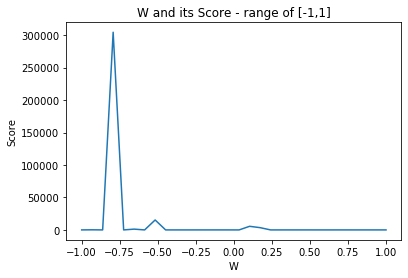

In [94]:
# Now to find the best w - let us take the alpha values for which we got the best result:
best_result = df.iloc[[0],:]
print(best_result)
alpha1 = best_result.iloc[0]['alpha 1']
alpha2 = best_result.iloc[0]['alpha 2']

w = np.linspace(-1,1,30)

all_possible_combinations = list(set(itertools.product(w,30*[alpha1], 30*[alpha2])))

result = automator(all_possible_combinations)
df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score','num_run'])
df.sort_values('w', inplace=True)

print(df)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
plt.plot(w,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('W and its Score - range of [-1,1]')
plt.xlabel("W")
plt.ylabel("Score")


plt.savefig('w_sphere.pdf') 

plt.show()

In [53]:






# df.sort_values('w', inplace=True)


df.sort_values('best_score', inplace=True)

print(df)

           w   alpha 1   alpha 2    best_score  num_run
23 -0.034483  1.235862  2.295172  7.547824e-10      999
10  0.034483  1.235862  2.295172  7.726470e-09      999
24 -0.103448  1.235862  2.295172  1.310712e-08      999
7  -0.241379  1.235862  2.295172  2.882573e-08      999
2  -0.724138  1.235862  2.295172  3.897548e-08      999
12 -0.172414  1.235862  2.295172  4.176152e-08      999
14 -0.448276  1.235862  2.295172  4.337651e-08      999
0   0.172414  1.235862  2.295172  4.731396e-08      999
16 -0.310345  1.235862  2.295172  5.253269e-08      999
25  1.000000  1.235862  2.295172  7.099546e-08      999
5   0.103448  1.235862  2.295172  7.692360e-08      999
8   0.241379  1.235862  2.295172  9.702249e-08      999
29  0.655172  1.235862  2.295172  1.113481e-07      999
1   0.310345  1.235862  2.295172  1.357621e-07      999
3   0.586207  1.235862  2.295172  1.438238e-07      999
21  0.379310  1.235862  2.295172  1.485898e-07      999
26 -0.586207  1.235862  2.295172  2.147423e-07  

### Performance based on N

           w   alpha 1   alpha 2    best_score  num_runs   n
67  0.176552  2.295172  1.010167      0.000026       999  68
87  0.176552  2.295172  1.010167      0.000043       999  88
78  0.176552  2.295172  1.010167      0.000046       999  79
92  0.176552  2.295172  1.010167      0.000047       999  93
98  0.176552  2.295172  1.010167      0.000048       999  99
..       ...       ...       ...           ...       ...  ..
4   0.176552  2.295172  1.010167   7925.665822       999   5
2   0.176552  2.295172  1.010167   8732.143771       999   3
3   0.176552  2.295172  1.010167   9412.466177       999   4
1   0.176552  2.295172  1.010167  16644.753065       999   2
0   0.176552  2.295172  1.010167  37657.315314       999   1

[99 rows x 6 columns]


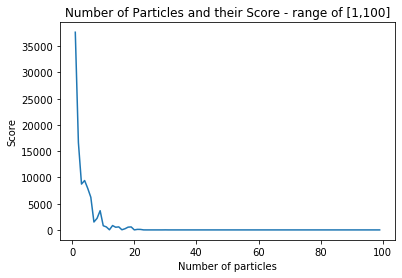

In [54]:
def automator_n(n_values,params):
    output = []
    for n in range(1,n_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=10, w=weight, a1=alpha1, a2=alpha2, a3=1, population_size=n, time_steps=1000, search_range=100).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,n))
    return output

params = [0.176552,2.295172,1.010167]
n_values = 100
result = automator_n(n_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','n'])

# printing the dataframe
df.sort_values('best_score', inplace=True)
print(df)

# plotting the data
df.sort_values('n', inplace=True)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their Score - range of [1,100]')
plt.xlabel("Number of particles")
plt.ylabel("Score")


plt.savefig('n_particles_sphere.pdf') 
plt.show()

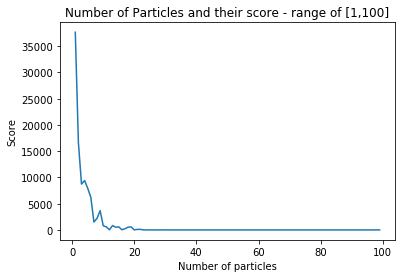

In [55]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their score - range of [1,100]')
plt.xlabel("Number of particles")
plt.ylabel("Score")


plt.savefig('n_particles_sphere.pdf') 


plt.show()


### Performanced based on D

           w   alpha 1   alpha 2    best_score  num_runs   d
0   0.176552  2.295172  1.010167  1.964144e-16       999   1
1   0.176552  2.295172  1.010167  3.613313e-09       999   2
2   0.176552  2.295172  1.010167  5.942871e-09       999   3
3   0.176552  2.295172  1.010167  1.037109e-07       999   4
4   0.176552  2.295172  1.010167  2.291041e-06       999   5
5   0.176552  2.295172  1.010167  7.655209e-06       999   6
6   0.176552  2.295172  1.010167  2.919172e-05       999   7
7   0.176552  2.295172  1.010167  3.314870e-05       999   8
8   0.176552  2.295172  1.010167  7.902425e-05       999   9
9   0.176552  2.295172  1.010167  1.222256e-04       999  10
10  0.176552  2.295172  1.010167  1.873902e-04       999  11
13  0.176552  2.295172  1.010167  2.470152e-04       999  14
11  0.176552  2.295172  1.010167  2.776204e-04       999  12
14  0.176552  2.295172  1.010167  3.803599e-04       999  15
12  0.176552  2.295172  1.010167  3.979235e-04       999  13
16  0.176552  2.295172  

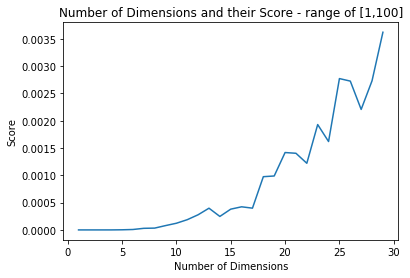

In [57]:
def automator_d(d_values,params):
    output = []
    for d in range(1,d_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=d, w=weight, a1=alpha1, a2=alpha2, a3=1, population_size=35, time_steps=1000, search_range=5.12).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,d))
    return output

params = [0.176552,2.295172,1.010167]
d_values = 30
result = automator_d(d_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','d'])

# printing the dataframe
df.sort_values('best_score', inplace=True)
print(df)

# plotting the data
df.sort_values('d', inplace=True)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")


plt.savefig('d_dimensions_sphere.pdf') 

plt.show()

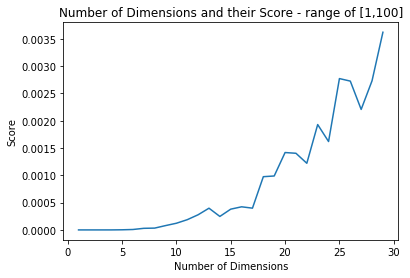

In [58]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")


plt.savefig('d_dimensions_sphere.pdf') 

plt.show()

# Rastrigin function

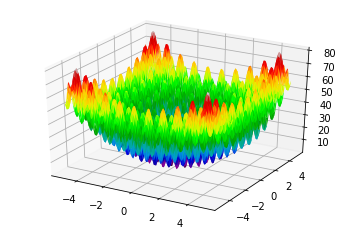

In [59]:
# Rastrigin

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
 
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y) 

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
 
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)    
# plt.imshow(Z)
plt.show()

## Finding best Alpha1 and Alpha2

In [60]:
alpha1 = np.linspace(-6.5,6.5,30)
alpha2 = np.linspace(-6.5,6.5,30)
# w = np.linspace(0,1,100)
w = 30*[0.1]

# random_combinations = random.sample(set(itertools.product(w,alpha1,alpha2)), 1000)
all_possible_combinations = list(set(itertools.product(w,alpha1, alpha2)))

def automator(random_combinations):
    output = []
    for params in random_combinations:
            weight = params[0]
            alpha1 = params[1]
            alpha2 = params[2]
            best_score,num_runs = PSO(dim=2, w=weight, a1=alpha1, a2=alpha2, a3=1, population_size=3, time_steps=20, search_range=100).run()
            output.append((weight,alpha1,alpha2,best_score,num_runs))
    return output
            
    
result = automator(all_possible_combinations)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs'])
df.sort_values('best_score', inplace=True)
print(df)



       w   alpha 1   alpha 2    best_score  num_runs
638  0.1  0.224138  2.465517  1.039438e-02        19
152  0.1  3.362069  2.913793  1.390049e-02        19
309  0.1  0.672414  0.672414  1.574154e-02        19
206  0.1  0.224138  2.017241  2.435746e-02        19
246  0.1  1.568966  1.120690  3.561718e-01        19
..   ...       ...       ...           ...       ...
682  0.1 -2.913793  5.603448  7.777360e+06        19
456  0.1 -5.603448 -5.603448  8.281441e+06        20
564  0.1 -4.258621  6.500000  8.644970e+06        19
893  0.1 -3.362069  6.500000  8.742838e+06        20
757  0.1 -5.603448 -6.500000  1.348268e+07        20

[900 rows x 5 columns]


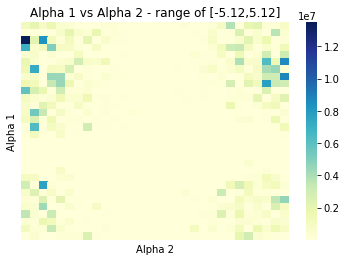

In [61]:
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
data = df.iloc[:,[1,2,3]]
data = data.pivot(index='alpha 1', columns='alpha 2', values='best_score')
sns.heatmap(data,xticklabels=False,yticklabels=False,cmap='YlGnBu')
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Alpha 1 vs Alpha 2 - range of [-5.12,5.12]')
plt.xlabel("Alpha 2")
plt.ylabel("Alpha 1")


plt.savefig('alpha1_alpha2_rastrigin.pdf') 

plt.show()

### Plotting alpha1 vs alpha2

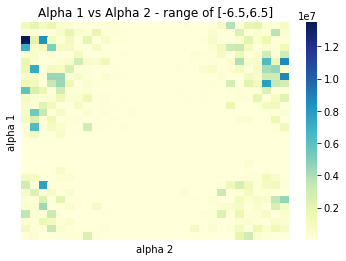

In [62]:
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
data = df.iloc[:,[1,2,3]]
data = data.pivot(index='alpha 1', columns='alpha 2', values='best_score')
sns.heatmap(data,xticklabels=False,yticklabels=False,cmap='YlGnBu')
plt.title('Alpha 1 vs Alpha 2 - range of [-6.5,6.5]')
plt.show()

## Finding best w

     w   alpha 1   alpha 2  best_score  num_runs
9 -1.0  0.224138  2.465517    0.026638        19
           w   alpha 1   alpha 2   best_score  num_runs
15  0.586207  0.224138  2.465517     0.000318        19
20 -0.241379  0.224138  2.465517     0.031620        19
0  -0.034483  0.224138  2.465517     0.123893        19
19 -0.793103  0.224138  2.465517     0.221598        19
22 -0.379310  0.224138  2.465517     0.476382        19
16 -0.931034  0.224138  2.465517     0.532066        19
26  0.517241  0.224138  2.465517     0.898478        19
4  -0.103448  0.224138  2.465517     1.076644        19
29 -0.655172  0.224138  2.465517     1.381810        19
17  0.241379  0.224138  2.465517     1.706836        19
3   0.724138  0.224138  2.465517     9.526877        19
1  -0.862069  0.224138  2.465517    10.336634        19
24  0.379310  0.224138  2.465517    14.985213        19
14  0.034483  0.224138  2.465517    22.529173        19
9  -1.000000  0.224138  2.465517    27.543185        19
5   1.

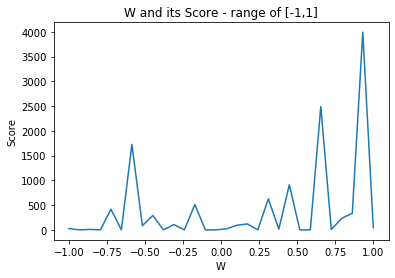

In [65]:
# Now to find the best w - let us take the alpha values for which we got the best result:
best_result = df.iloc[[0],:]
print(best_result)
alpha1 = best_result.iloc[0]['alpha 1']
alpha2 = best_result.iloc[0]['alpha 2']

w = np.linspace(-1,1,30)

all_possible_combinations = list(set(itertools.product(w,30*[alpha1], 30*[alpha2])))

result = automator(all_possible_combinations)
df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score','num_runs'])


# printing the dataframe
df.sort_values('best_score', inplace=True)
print(df)

# plotting the data
df.sort_values('w', inplace=True)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
plt.plot(w,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('W and its Score - range of [-1,1]')
plt.xlabel("W")
plt.ylabel("Score")


plt.savefig('w_rastrigin.pdf') 

plt.show()

### Performance based on N

           w   alpha 1   alpha 2    best_score  num_runs   n
92  0.176552  2.295172  1.010167      0.000037       999  93
90  0.176552  2.295172  1.010167      0.000045       999  91
55  0.176552  2.295172  1.010167      0.000050       999  56
97  0.176552  2.295172  1.010167      0.000057       999  98
52  0.176552  2.295172  1.010167      0.000058       999  53
..       ...       ...       ...           ...       ...  ..
4   0.176552  2.295172  1.010167   6635.569883       999   5
3   0.176552  2.295172  1.010167   6877.543785       999   4
2   0.176552  2.295172  1.010167   8007.688999       999   3
1   0.176552  2.295172  1.010167  13459.310568       999   2
0   0.176552  2.295172  1.010167  41363.235963       999   1

[99 rows x 6 columns]


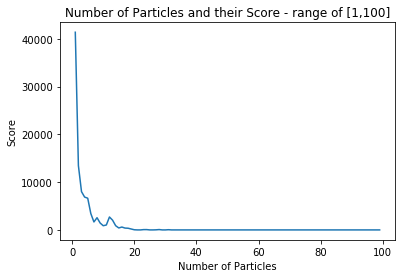

In [67]:
def automator_n(n_values,params):
    output = []
    for n in range(1,n_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=10, w=weight, a1=alpha1, a2=alpha2, a3=1, population_size=n, time_steps=1000, search_range=100).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,n))
    return output

params = [0.176552,2.295172,1.010167]
n_values = 100
result = automator_n(n_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','n'])
# printing the dataframe
df.sort_values('best_score', inplace=True)
print(df)

# plotting the data
df.sort_values('n', inplace=True)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their Score - range of [1,100]')
plt.xlabel("Number of Particles")
plt.ylabel("Score")


plt.savefig('n_particles_rastrigin.pdf') 

plt.show()

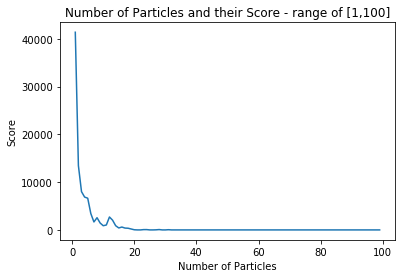

In [68]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
n = df.iloc[:,[5]]
plt.plot(n,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Particles and their Score - range of [1,100]')
plt.xlabel("Number of Particles")
plt.ylabel("Score")


plt.savefig('n_particles_rastrigin.pdf') 

plt.show()

### Performance based on D

           w   alpha 1   alpha 2    best_score  num_runs   d
67  0.176552  2.295172  1.010167      0.000031       999  68
86  0.176552  2.295172  1.010167      0.000035       999  87
88  0.176552  2.295172  1.010167      0.000040       999  89
53  0.176552  2.295172  1.010167      0.000050       999  54
68  0.176552  2.295172  1.010167      0.000050       999  69
..       ...       ...       ...           ...       ...  ..
3   0.176552  2.295172  1.010167   3396.040287       999   4
10  0.176552  2.295172  1.010167   3944.412386       999  11
1   0.176552  2.295172  1.010167   9305.478814       999   2
2   0.176552  2.295172  1.010167  19213.049792       999   3
0   0.176552  2.295172  1.010167  44865.775524       999   1

[99 rows x 6 columns]


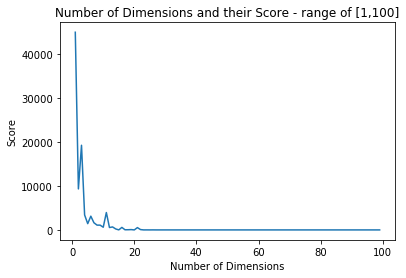

In [69]:
def automator_d(d_values,params):
    output = []
    for d in range(1,d_values):
        weight = params[0]
        alpha1 = params[1]
        alpha2 = params[2]
        best_score,num_runs = PSO(dim=d, w=weight, a1=alpha1, a2=alpha2, population_size=35, time_steps=1000, search_range=5.12).run()
        output.append((weight,alpha1,alpha2,best_score,num_runs,d))
    return output

params = [0.176552,2.295172,1.010167]
n_values = 100
result = automator_n(n_values,params)

df = pd.DataFrame(result, columns=['w', 'alpha 1', 'alpha 2', 'best_score', 'num_runs','d'])
# printing the dataframe
df.sort_values('best_score', inplace=True)
print(df)

# plotting the data
df.sort_values('d', inplace=True)

w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")


plt.savefig('d_dimensions_rastrigin.pdf') 

plt.show()

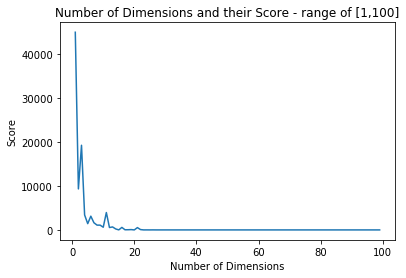

In [70]:
w = df.iloc[:,[0]]
a1 = df.iloc[:,[1]]
a2 = df.iloc[:,[2]]
score = df.iloc[:,[3]]
data = df.iloc[:,[0,2,3]]
d = df.iloc[:,[5]]
plt.plot(d,score)
# plt.imshow(data, cmap='hot', interpolation='nearest')
plt.title('Number of Dimensions and their Score - range of [1,100]')
plt.xlabel("Number of Dimensions")
plt.ylabel("Score")
-0.224138  2.913793

plt.savefig('d_dimensions_rastrigin.pdf') 

plt.show()